# Online Drift Detection on the Wine Quality Dataset

In the context of deployed models, data (model queries) usually arrive sequentially and we wish to detect it as soon as possible after its occurence. One approach is to perform a test for drift every $W$ time-steps, using the $W$ samples that have arrived since the last test. Such a strategy could be implemented using any of the offline detectors implemented in `alibi-detect`, but being both sensitive to slight drift and responsive to severe drift is difficult. If the window size $W$ is too small then slight drift will be undetectable. If it is too large then the delay between test-points hampers responsiveness to severe drift.

An alternative strategy is to perform a test each time data arrives. However the usual offline methods are not applicable because the process for computing p-values is too expensive and doesn't account for correlated test outcomes when using overlapping windows of test data. 

Online detectors instead work by computing the test-statistic once using the first $W$ data points and then updating the test-statistic sequentially at low cost. When no drift has occured the test-statistic fluctuates around its expected value and once drift occurs the test-statistic starts to drift upwards. When it exceeds some preconfigured threshold value, drift is detected.

Unlike offline detectors which require the specification of a threshold p-value (a false positive rate), the online detectors in `alibi-detect` require the specification of an expected run-time (ERT) (an inverted FPR). This is the number of time-steps that we insist our detectors, on average, should run for in the absense of drift before making a false detection. Usually we would like the ERT to be large, however this results in insensitive detectors which are slow to respond when drift does occur. There is a tradeoff between the expected run time and the expected detection delay. 

To target the desired ERT, thresholds are configured during an initial configuration phase via simulation. This configuration process is only suitable when the amount reference data (most likely the training data of the model of interest) is relatively large (ideally around an order of magnitude larger than the desired ERT). Configuration can be expensive (less so with a GPU) but allows the detector to operate at low-cost during deployment. 

This notebook demonstrates online drift detection using two different two-sample distance metrics for the test-statistic, the maximum mean discrepency (MMD) and least-squared density difference (LSDD), both of which can be updated sequentially at low cost. 

### Backend

The online detectors are implemented in both the *PyTorch* and *TensorFlow* frameworks with support for CPU and GPU. Various preprocessing steps are also supported out-of-the box in Alibi Detect for both frameworks and an example will be given in this notebook. Alibi Detect does however not install PyTorch for you. Check the [PyTorch docs](https://pytorch.org/) how to do this. 

### Dataset

The [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality) consists of 4898 and 1599 samples of white and red wine respectively. Each sample has an associated quality (as determined by experts) and 11 numeric features indicating its acidity, density, pH etc. We consider the regression problem of tring to predict the quality of white wine samples given these features. We will then consider whether the model remains suitable for predicting the quality of red wine samples or whether the associated change in the underlying distribution should be considered as drift.

## Online detection with MMD and Pytorch

The Maximum Mean Discepency (MMD) is a distance-based measure between 2 distributions *p* and *q* based on the mean embeddings $\mu_{p}$ and $\mu_{q}$ in a reproducing kernel Hilbert space $F$:

\begin{align}
MMD(F, p, q) & = || \mu_{p} - \mu_{q} ||^2_{F} \\
\end{align}

Given reference samples $\{X_i\}_{i=1}^{N}$ and test samples $\{Y_i\}_{i=t}^{t+W}$ we may compute an unbiased estimate $\widehat{MMD}^2(F, \{X_i\}_{i=1}^N, \{Y_i\}_{i=t}^{t+W})$ of the squared MMD between the two underlying distributions. Depending on the size of the reference and test windows, $N$ and $W$ respectively, this can be relatively expensive. However, once computed it is possible to update the statistic to estimate to the squared MMD between the distributions underlying $\{X_i\}_{i=1}^{N}$ and $\{Y_i\}_{i=t+1}^{t+1+W}$ at a very low cost, making it suitable for online drift detection.

By default we use a [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), but users are free to pass their own kernel of preference to the detector.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorflow as tf
from torch import nn
import pandas as pd
import scipy

from alibi_detect.models.pytorch.trainer import trainer
from alibi_detect.cd.utils import encompass_batching

np.random.seed(0)
torch.manual_seed(0)
tf.random.set_seed(0)

### Load data

First we load in the data:

In [2]:
red = pd.read_csv(
    "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-red.csv", sep=';'
)
white = pd.read_csv(
    "https://storage.googleapis.com/seldon-datasets/wine_quality/winequality-white.csv", sep=';'
)
white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


We can see that the data for both red and white wine samples take the same format.

In [3]:
red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


We shuffle and normalise the data such that each feature takes a value in \[0,1\], as does the quality we seek to predict. We assue that our model was trained on white wine samples, which therefore forms the reference distribution, and that red wine samples can be considered to be drawn from a drifted distribution.

In [4]:
white, red = np.asarray(white, np.float32), np.asarray(red, np.float32)
n_white, n_red = white.shape[0], red.shape[0]

col_maxes = white.max(axis=0)
white, red = white / col_maxes, red / col_maxes
white, red = white[np.random.permutation(n_white)], red[np.random.permutation(n_red)]
X = white[:, :-1]
X_corr = red[:, :-1]

Although it may not be necessary on this relatively low-dimensional data for which individual features are semantically meaningful, we demonstrate how a preprocessing stage can be defined to project raw data onto a lower dimensional representation which more concisely captures the factors of variation in the data. As not to bias the detector it is necessary to learn the projection using a split of the data which isn't then passed as reference data. We additionally split off some white wine samples to act as undrifted data during deployment.

In [5]:
X_train = X[:(n_white//2)]
X_ref = X[(n_white//2):(3*n_white//4)]
X_h0 = X[(3*n_white//4):]

X_train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(X_train))
X_train_dl = torch.utils.data.DataLoader(X_train_ds, batch_size=32, shuffle=True, drop_last=True)

Now we define and fit an autoencder so that we can use the encoder as a preprocessing function which projects the 11-D data onto a 2-D representation.

In [6]:
encoder = nn.Sequential(
    nn.Linear(11, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)
decoder = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 11)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ae = nn.Sequential(encoder, decoder).to(device)

trainer(ae, nn.MSELoss(), X_train_dl, device, torch.optim.Adam, learning_rate=0.001, epochs=10)

/home/oliver/Projects/alibi-detect/.venv/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
Epoch 10/10: 100%|██████████| 76/76 [00:00<00:00, 211.75it/s, loss=0.00448]


The autoencoder was fit to data from the reference distribution (white wine samples) and should therefore more accurately reconstruct white wine samples than red.

In [7]:
ae = ae.eval()
ae_fn = encompass_batching(ae, backend='pytorch', batch_size=32)
recon_ref = ae_fn(X_ref)
recon_corr = ae_fn(X_corr)

ref_mse = np.square(recon_ref - X_ref).mean()
corr_mse = np.square(recon_corr - X_corr).mean()

print(f'MSE when reconstructing unseen white wine samples: {ref_mse}')
print(f'MSE when reconstructing unseen red wine samples: {corr_mse}')

MSE when reconstructing unseen white wine samples: 0.005474736448377371
MSE when reconstructing unseen red wine samples: 0.024097805842757225


Hopefully the learned preprocessing step has learned a projection such that in the lower dimensional space the two samples are distinguishable.

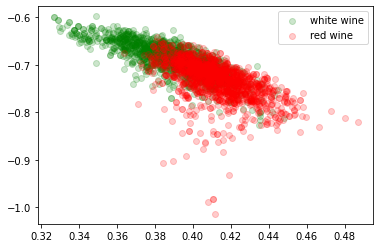

In [8]:
encoder_fn = encompass_batching(encoder, backend='pytorch', batch_size=32)
enc_h0 = encoder_fn(X_h0)
enc_h1 = encoder_fn(X_corr)

plt.scatter(enc_h0[:,0], enc_h0[:,1], alpha=0.2, color='green', label='white wine')
plt.scatter(enc_h1[:,0], enc_h1[:,1], alpha=0.2, color='red', label='red wine')
plt.legend(loc='upper right')
plt.show()

Now we can define our online drift detector. We specify an expected run-time (in the absence of drift) of 50 time-steps, and a window size of 10 time-steps. Upon initialising the detector thresholds will be computed using 2500 boostrap samples. These values of `ert`, `window_size` and `n_bootstraps` are lower than a typical use-case in order to demonstrate the average behaviour of the detector over a large number of runs in a reasonable time. 

In [9]:
from alibi_detect.cd import MMDDriftOnline

ert = 50
window_size = 10

cd = MMDDriftOnline(
    X_ref, ert, window_size, backend='pytorch', preprocess_fn=encoder_fn, n_bootstraps=2500
)

No GPU detected, fall back on CPU.
Computing thresholds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


We now define a function which will simulate a single run and return the run-time. Note how the detector acts on single instances at a time, the run-time is considered as the time elapsed after the test-window has been filled, and that the detector is stateful and must be reset between detections.

In [10]:
def time_run(cd, X, window_size):
    n = X.shape[0]
    perm = np.random.permutation(n)
    t = 0
    cd.reset()
    while True:
        pred = cd.predict(X[perm[t%n]])
        if pred['data']['is_drift'] == 1:
            return t
        else:
            t += 1

Now we look at the distribution of run-times when operating on the held-out data from the reference distribution of white wine samples. We report the average run-time, however note that the targeted run-time distribution, a Geometric distribution with mean `ert`, is very high variance so the empirical average may not be that close to `ert` over a relatively small number of runs. We can see that the detector accurately targets the desired Geometric distribution however by inspecting the linearity of a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot).

Average run-time under no-drift: 43.728


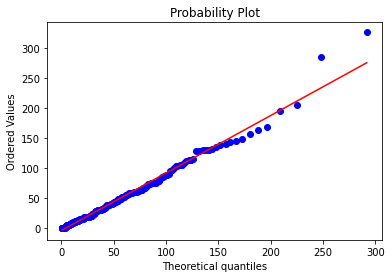

In [11]:
n_runs = 250
times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]
print(f"Average run-time under no-drift: {np.mean(times_h0)}")
_ = scipy.stats.probplot(np.array(times_h0), dist=scipy.stats.geom, sparams=1/ert, plot=plt)

If we run the detector in an identical manner but on data from the drifted distribution of red wine samples the average run-time is much lower.

In [12]:
n_runs = 250
times_h1 = [time_run(cd, X_corr, window_size) for _ in range(n_runs)]
print(f"Average run-time under drift: {np.mean(times_h1)}")

Average run-time under drift: 5.456


## Online detection with LSDD and TensorFlow

Here we address the same problem but using the least squares density difference (LSDD) as the two-sample distance in a manner similar to [Bu et al. (2017)](https://ieeexplore.ieee.org/abstract/document/7890493). The LSDD between two distributions $p$ and $q$ on $\mathcal{X}$ is defined as $$LSDD(p,q) = \int_{\mathcal{X}} (p(x)-q(x))^2 \,dx$$ and also has an empirical estimate $\widehat{LSDD}(\{X_i\}_{i=1}^N, \{Y_i\}_{i=t}^{t+W})$ that can be updated at low cost as the test window is updated to $\{Y_i\}_{i=t+1}^{t+1+W}$.

We additionally show that TensorFlow can also be used as the backend and that sometimes it is not necessary to perform preprocessing, making definition of the drift detector simpler. Moreover, in the absence of a learned preprocessing stage we may use all of the reference data available.

In [13]:
X_ref = np.concatenate([X_train, X_ref], axis=0)

And now we define the LSDD-based online drift detector, again with an `ert` of 50 and `window_size` of 10.

In [14]:
from alibi_detect.cd import LSDDDriftOnline

cd = LSDDDriftOnline(
    X_ref, ert, window_size, backend='tensorflow', n_bootstraps=2500,
)

Computing thresholds: 100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


We run this new detector on the held out reference data and again see that in the absence of drift the distribution of run-times follows a Geometric distribution with mean `ert`.

Average run-time under no-drift: 51.164


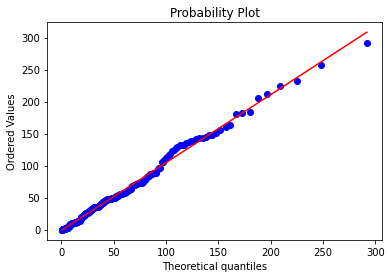

In [15]:
n_runs = 250
times_h0 = [time_run(cd, X_h0, window_size) for _ in range(n_runs)]
print(f"Average run-time under no-drift: {np.mean(times_h0)}")
_ = scipy.stats.probplot(np.array(times_h0), dist=scipy.stats.geom, sparams=1/ert, plot=plt)

And when drift has occured the detector is very fast to respond.

In [16]:
n_runs = 250
times_h1 = [time_run(cd, X_corr, window_size) for _ in range(n_runs)]
print(f"Average run-time under drift: {np.mean(times_h1)}")

Average run-time under drift: 4.176
